# Intro

In this notebook we're going to analyze and compare the outputs of axial plane tumor detection models built using Azure Cognitive services and YOLOv5.
Further info about [test_results.csv](https://github.com/giuseppebrb/BrainTumorDetection/blob/main/test_results.csv) and its generation can be found in the notebook [Test_Detection.ipynb](https://github.com/giuseppebrb/BrainTumorDetection/blob/main/Test_Detection.ipynb).

In [119]:
# Global imports
import numpy as np
import csv
import os
import urllib.request
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn import metrics

In [120]:
# Download and unzip the dataset
if not os.path.isfile('data.zip'):
  urllib.request.urlretrieve("https://github.com/giuseppebrb/BrainTumorDetection/blob/main/data.zip?raw=true", "data.zip")

with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

os.remove('data.zip')

We'll now define two functions in order to perform a conversion from YOLO annotations and Azure predictions coordinates into pixels.
Both YOLO and Azure coordinates are provided as normalized values within the range [0, 1], further more the x and y coordinates of YOLO annotations are given considering the median values of the bounding box.

In [121]:
def YOLO_BB_to_pixels(yolo_bounding_box, image_width, image_height):
    if (yolo_bounding_box == 'Healthy' or yolo_bounding_box == 'Actual label not found'):
        return None
    yolo_bounding_box = yolo_bounding_box.replace('\n', '')
    yolo_bounding_box = yolo_bounding_box.split(', ')
    yolo_bounding_box = np.array(yolo_bounding_box,dtype=float)
    x_normalized, y_normalized, width_normalized, height_normalized = yolo_bounding_box
    x = (x_normalized - (width_normalized / 2)) * image_width
    y = (y_normalized - (height_normalized / 2)) * image_height
    width = width_normalized * image_width
    height = height_normalized * image_height
    return [x, y, width, height]


def Azure_prediction_to_pixels(azure_bounding_box, image_width, image_height):
    azure_bounding_box = azure_bounding_box.split(', ')
    azure_bounding_box = np.array(azure_bounding_box,dtype=float)
    x_normalized, y_normalized, width_normalized, height_normalized = azure_bounding_box
    x = x_normalized * image_width
    y = y_normalized * image_height
    width = width_normalized * image_width
    height = height_normalized * image_height
    return[x, y, width, height]

Now we'll define a function to determine the percentage of intersection between the two boxes: <br />
100% means that manual annotation and prediction areas match perfectly <br />
0% means they are highlighting two totally different areas.

In [122]:
import pdb


def calculate_overlap_percentage(yolo_bb, azure_bb, yolo_tag, azure_tag):
    if (yolo_bb == azure_bb or (yolo_bb == None and azure_bb != None) or yolo_tag.__eq__(azure_tag)):
        return 100
    yolo_x, yolo_y, yolo_width, yolo_height = yolo_bb
    azure_x, azure_y, azure_width, azure_height = azure_bb
    SI = max(0, min(yolo_x + yolo_width, azure_x + azure_width) - max(yolo_x, azure_x)) * max(0, min(yolo_y + yolo_height, azure_y + azure_height) - max(yolo_y, azure_y))
    SU = (yolo_width * yolo_height) + (azure_width * azure_height) - SI
    return round((SI / SU) * 100, 2)

Let's iterate through the entire test set and let's convert the coordinates into pixel values.

In [123]:
image_folder = "data/axial/images/validation/"
converted_coordinates = []
with open('test_results.csv', newline='') as csvfile:
    result_reader = csv.reader(csvfile)
    next(result_reader, None)
    for row in result_reader:
        if(row[0].startswith('.')):
            continue
        im = Image.open(image_folder + row[0])
        width, height = im.size
        converted_coordinates.append([row[0], YOLO_BB_to_pixels(row[4], width, height), Azure_prediction_to_pixels(row[3], width, height), row[4], row[1]])

Now we can perform operations and comparations between the actual bounding boxes and predicted ones. For example, let's pick an image and draw both boxes.

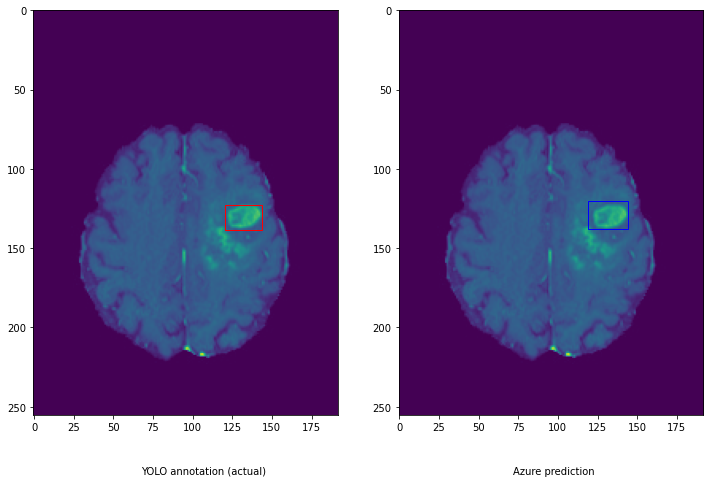

Area match:  78.27%


In [124]:
example_image = '00340_132.jpg'
image_data = [x for x in converted_coordinates if x[0] == example_image][0]
yolo_x, yolo_y, yolo_width, yolo_height = image_data[1]
azure_x, azure_y, azure_width, azure_height = image_data[2]

img = Image.open(image_folder + example_image)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Display the image
ax[0].imshow(img) # YOLO annotation bounding box
ax[1].imshow(img) # Azure prediction bounding box

# Create a Rectangle patch
yolo_bb = patches.Rectangle((yolo_x, yolo_y), yolo_width, yolo_height, linewidth=1, edgecolor='r', facecolor='none')
azure_bb = patches.Rectangle((azure_x, azure_y), azure_width, azure_height, linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax[0].add_patch(yolo_bb)
ax[1].add_patch(azure_bb)
fig.text(.25,0.2,'YOLO annotation (actual)')
fig.text(.68,0.2,'Azure prediction')

plt.show()

print('Area match: ', str(calculate_overlap_percentage(image_data[1], image_data[2], image_data[3], image_data[4]))+'%')

Now we can iterate this process on the entire test results file, and we can build a confusion matrix based on the predictions.

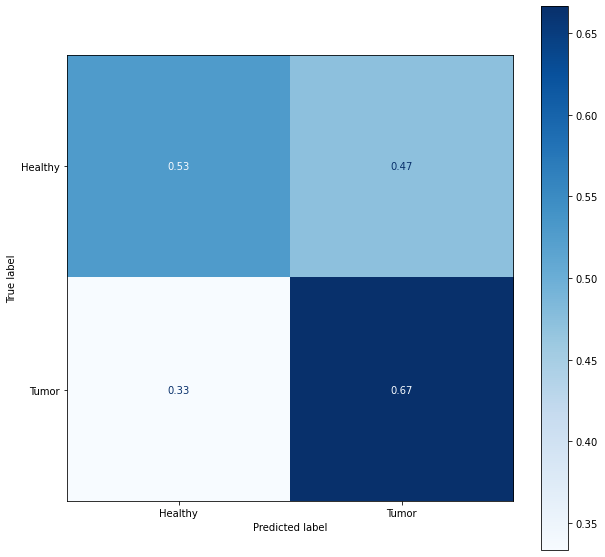

In [126]:
actual_values = np.array([], dtype=int)
predicted_values = np.array([], dtype=int)
for row in converted_coordinates:
    image_name = row[0]
    actual_coordinates = row[1]
    predicted_coordinates = row[2]
    yolo_tag = row[3]
    azure_tag = row[4]

    if(actual_coordinates != None):
        actual_values = np.append(actual_values, 1)
    else:
        actual_values = np.append(actual_values, 0)

    # if overlap score is higher or equal 70% we'll consider it as a good evaluation
    if (calculate_overlap_percentage(actual_coordinates, predicted_coordinates, yolo_tag, azure_tag) >= 70 and azure_tag != 'Healthy'):
        predicted_values = np.append(predicted_values, 1)
    else:
        predicted_values = np.append(predicted_values, 0)
confusion_matrix = metrics.confusion_matrix(actual_values, predicted_values, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Healthy', 'Tumor'])
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()
    